In [61]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats.mstats import winsorize
from indicator.indicator import Indicator

In [26]:
chung = ADatabase("chung")
market = ADatabase("market")

In [40]:
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) if np.std(returns) > 0 else np.nan

def sortino_ratio(returns):
    downside_returns = returns[returns < 0]
    return np.mean(returns) / np.std(downside_returns) if np.std(downside_returns) > 0 else np.nan


In [52]:
chung.connect()
product = chung.retrieve("sim")
chung.disconnect()
product = p.column_date_processing(product).sort_values("date")

In [53]:
product.columns

Index(['year', 'week', 'ticker', 'date', 'adjclose', 'sell_price',
       'market_cap', 'adr', 'sma', 'ema', 'bollinger_upper', 'bollinger_lower',
       'pct_change', 'coev', 'market_impact', 'atr', 'momentum', 'roc',
       'williams_r', 'obv', 'vwap', 'rogan', 'y', 'market_cap_rank'],
      dtype='object')

In [54]:
product["return"] = product["sell_price"]/product["adjclose"]
product["count"] = 1
product["month"] = product["date"].dt.month
product["return"] = winsorize(product["return"], limits=[.01, .01])

In [55]:
yearly_metrics = product.groupby(["year","month"]).agg(
    annual_return=("return", "mean"),
    annual_volatility=("return", "std"),
    sharpe=("return", sharpe_ratio),
    coev=("coev", "mean"),
    count=("count", "sum")
).reset_index()
yearly_metrics["annual_return"] = yearly_metrics["annual_return"] -1
# Print results
yearly_metrics

,year,month,annual_return,annual_volatility,sharpe,coev,count
0,2004,8,0.011294,0.051944,19.478235,0.093996,1041
1,2004,9,0.005479,0.044504,22.598217,0.089850,2088
2,2004,10,0.006519,0.054613,18.433536,0.086188,2623
3,2004,11,0.016307,0.059213,17.167713,0.088175,2110
4,2004,12,0.004875,0.055992,17.952355,0.096510,1585
...,...,...,...,...,...,...,...
243,2024,11,0.003766,0.087894,11.421033,0.446379,7167
244,2024,12,-0.015570,0.087185,11.292609,0.456077,4322
245,2025,1,-0.005825,0.077754,12.787231,0.462720,5797
246,2025,2,-0.004600,0.075265,13.226352,0.474997,5833


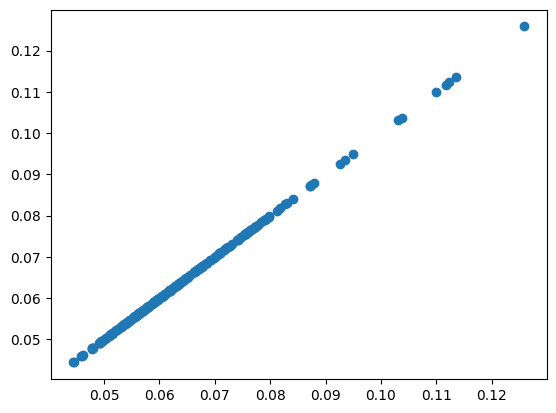

In [69]:
plt.scatter(yearly_metrics["annual_volatility"],yearly_metrics["annual_volatility"])
plt.show()

In [58]:
double_money = product.copy()

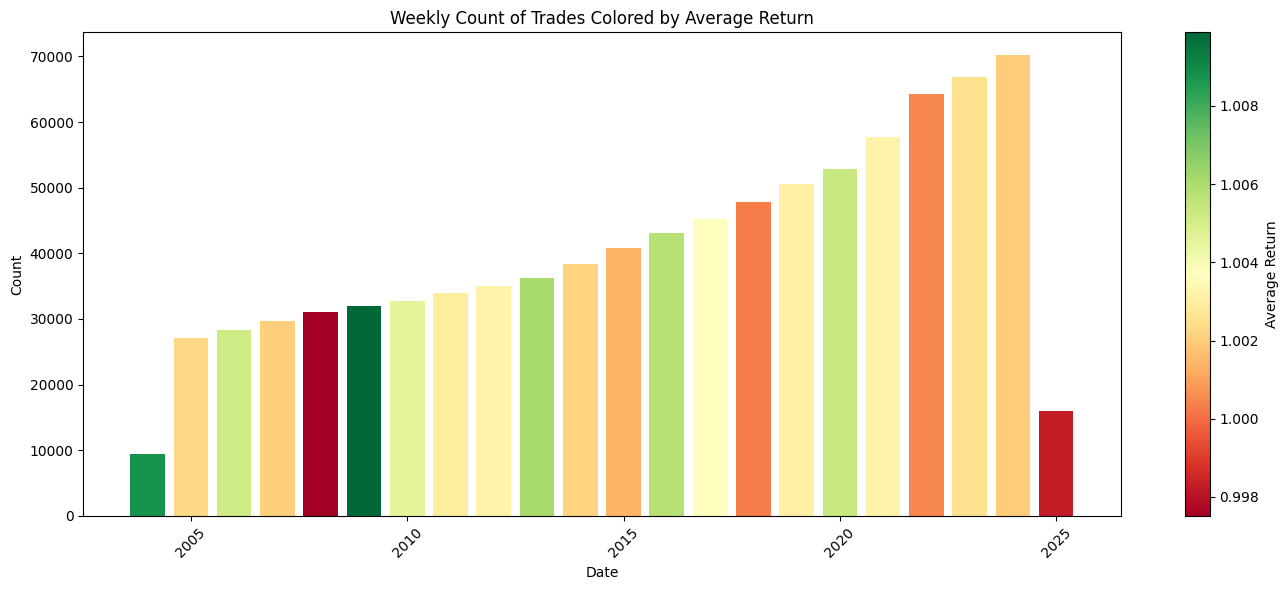

In [59]:
grouped = double_money.groupby(["year"]).agg({
    "return": "mean",
    "coev": "mean",
    "count": "sum",
    "adjclose": "mean",
    "market_cap": "mean"
}).reset_index()

# Create 'date' column
# grouped['date'] = pd.to_datetime(grouped['year'].astype(str) + '-' + grouped['week'].astype(str) + '-1', format='%G-%V-%u')

# Normalize return for color mapping
norm = mcolors.Normalize(vmin=grouped['return'].min(), vmax=grouped['return'].max())
cmap = plt.get_cmap('RdYlGn')
colors = cmap(norm(grouped['return']))

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 6))

# Plot bar chart
bars = ax.bar(grouped['year'], grouped['count'], color=colors)

# Create ScalarMappable for colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array needed for colorbar

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Average Return')

# Labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Weekly Count of Trades Colored by Average Return')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [63]:
signals = Indicator.get_trading_signals()
product[["return"] + signals].sort_values("return",ascending=False).corr().sort_values("return")

,return,adr,sma,ema,bollinger_upper,bollinger_lower,pct_change,coev,market_impact,atr,momentum,roc,williams_r,obv,vwap,rogan
market_impact,-0.009999,0.063999,0.000205,0.000223,0.000928,-0.000907,-0.000333,0.001072,1.000000,0.003459,-0.000060,-0.000333,-0.000334,0.029213,-0.000576,-0.000502
obv,-0.009921,0.001426,-0.000026,0.003802,0.048059,-0.048770,-0.001538,0.060545,0.029213,-0.017298,-0.000239,-0.001538,-0.000574,1.000000,-0.017880,-0.015341
bollinger_lower,-0.003788,0.000586,0.000157,-0.527427,-0.985480,1.000000,0.000045,-0.954167,-0.000907,0.001889,0.000293,0.000045,0.000030,-0.048770,0.000064,-0.000062
atr,-0.002617,0.016608,-0.001941,-0.001588,-0.002192,0.001889,-0.001011,-0.001879,0.003459,1.000000,-0.000660,-0.001011,-0.001216,-0.017298,0.000424,0.000368
rogan,-0.001910,-0.000155,-0.000014,-0.000021,0.000059,-0.000062,-0.000081,0.000094,-0.000502,0.000368,-0.000019,-0.000081,-0.000169,-0.015341,0.999997,1.000000
vwap,-0.001882,-0.000154,-0.000014,-0.000031,-0.000065,0.000064,-0.000076,-0.000062,-0.000576,0.000424,-0.000016,-0.000076,-0.000036,-0.017880,1.000000,0.999997
momentum,-0.001274,-0.000066,-0.002796,-0.000502,-0.000763,0.000293,0.006397,0.000045,-0.000060,-0.000660,1.000000,0.006397,0.018194,-0.000239,-0.000016,-0.000019
williams_r,-0.000244,-0.000446,-0.000039,-0.000027,-0.000036,0.000030,-0.000010,-0.000028,-0.000334,-0.001216,0.018194,-0.000010,1.000000,-0.000574,-0.000036,-0.000169
pct_change,0.000034,-0.000410,-0.000502,-0.000190,-0.000130,0.000045,1.000000,0.000127,-0.000333,-0.001011,0.006397,1.000000,-0.000010,-0.001538,-0.000076,-0.000081
roc,0.000034,-0.000410,-0.000502,-0.000190,-0.000130,0.000045,1.000000,0.000127,-0.000333,-0.001011,0.006397,1.000000,-0.000010,-0.001538,-0.000076,-0.000081


In [68]:
product["market_cap_rank_rounded"] = product["market_cap_rank"].round(1)
required = 1.00
return_ceiling = np.inf

cap_floors = np.round(np.arange(0.7, 1.0, 0.1), 2)  # 0.7 to 1.0 inclusive

# Initialize list to collect data
stats = []

for cap_floor in cap_floors:
    view = product[
        (product["return"] < return_ceiling) &
        (product["market_cap_rank_rounded"] == cap_floor)
    ]

    if not view.empty:
        ratio = view[view["return"] > required].index.size / view.index.size
        max_return = view["return"].max()
        min_return = view["return"].min()
        average_gain = view[view["return"] >= required]["return"].mean()
        average_loss = view[view["return"] < required]["return"].mean()
        ar = view["return"].mean()

        stats.append({
            "cap_floor": cap_floor,
            "ratio": ratio,
            "average_return": ar,
            "max_return": max_return,
            "min_return": min_return,
            "average_gain": average_gain,
            "average_loss": average_loss,
            "sample_size": view.index.size
        })
    else:
        stats.append({
            "cap_floor": cap_floor,
            "ratio": np.nan,
            "average_return": np.nan,
            "max_return": np.nan,
            "min_return": np.nan,
            "average_gain": np.nan,
            "average_loss": np.nan,
            "sample_size": 0
        })

# Convert to DataFrame and sort by average return
stats_df = pd.DataFrame(stats).sort_values("average_return", ascending=False)
stats_df


,cap_floor,ratio,average_return,max_return,min_return,average_gain,average_loss,sample_size
3,1.0,0.400584,1.003830,1.278107,0.8,1.037440,0.952664,148643
2,0.9,0.477258,1.003204,1.278107,0.8,1.042835,0.958586,296146
1,0.8,0.490341,1.002761,1.278107,0.8,1.045148,0.957493,296361
0,0.7,0.494694,1.002300,1.278107,0.8,1.045616,0.956541,148029
